
**Submission Deadline**: Feb 07, 2024; 11:59 PM

Welcome to the programming assignments (PAs) for *ECE 5995: Large Language Models*. For the PAs, we'll be using Python. Python has fantastic community support and have posted several resources in ICON to help you better familiarize with it.

**Learning Objectives**

In this assignment, we will perform language modeling using the *WikiText* dataset, which contains a large collection of text from Wikipedia articles. The task involves training models to generate coherent and contextually appropriate text, making it a fundamental problem in natural language processing.

**Writing Code**

Look for the keyword "TODO" and fill in your code in the empty space. Feel free to add and delete arguments in function signatures, but be careful that you might need to change them in function calls which are already present in the notebook.

# 1: N-Gram Language Modeling:  

In the context of n-grams, language modeling involes estimating the likelihood of a sequence of words/tokens based on the history of preceding words.


The goal of this portion of the assignment is to implement n-gram language models for values of $n \in [ 2, 4, 8]$, generate sample text, and calculate the perplexity of each n-gram model on the train set.

*Note: The dataset for this PA is can be found in ICON. Please do not forget to upload the data folder (i.e., wiki dataset) to your notebook. *

## 1.1 Data Preprocessing :

###### Complete the following code block to create the tokenizer necessary for the proceeeding experiments

- Create the train tokenizer with the following properties
    - Add a special **\<unk\>** token to replace any out of vocabularly (OOV) tokens
    - Replace numeric tokens with the **\<num\>** token
    - Remove punctuation and symbols
    - Ensure the tokenizer prepends a **\<bos\>** and appends an **\<eos\>** token to every sequence
    
**TODO**
- Train the tokenizer on the train set of Wiki-Text

- Print the vocabulary size of the tokenizer
- **Note:** You may want to make use of the [huggingface tokenizer docs.](https://huggingface.co/docs/tokenizers/components)

In [2]:
from typing import List, Tuple, Callable
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.util import ngrams
from nltk.lm import MLE
from nltk.tokenize import word_tokenize
import string as string
import numpy as np

In [3]:
import tokenizers
from tokenizers.pre_tokenizers import WhitespaceSplit, Sequence
from tokenizers import Tokenizer, normalizers, Regex
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.processors import TemplateProcessing

In [4]:
# define the tokenizer with the help of the huggingface docs:
# https://huggingface.co/docs/tokenizers/index
# more tokenizers
from tokenizers.pre_tokenizers import Digits, Punctuation
from tokenizers.normalizers import Lowercase, Replace

def train_tokenizer(fname: str) -> tokenizers.Tokenizer:
    """
    Args:
        fname: the name of the wiki.txt file

    Returns: Huggingface Tokenizer
    """
    PAD_TOKEN = '<pad>'
    UNK_TOKEN = '<unk>'
    NUM_TOKEN = '<num>'
    START_TOKEN= '<bos>'
    END_TOKEN= '<eos>'
    tokenizer = Tokenizer(WordLevel(unk_token=UNK_TOKEN))
    # =============================
    # TODO:
    tokenizer.normalizer = normalizers.Sequence([
        Lowercase(), 
        Replace(Regex(r'\d+'), NUM_TOKEN)
    ])

    tokenizer.pre_tokenizer = WhitespaceSplit()

    tokenizer.post_processor = TemplateProcessing(
        single=f"{START_TOKEN} $A {END_TOKEN}",
        special_tokens=[(START_TOKEN, 1), (END_TOKEN, 2)]
    )

    trainer = WordLevelTrainer(
        special_tokens=[PAD_TOKEN, UNK_TOKEN, NUM_TOKEN, START_TOKEN, END_TOKEN],
        min_frequency=2
    )

    with open(fname, "r", encoding="utf-8") as f:
        text = f.readlines()

    tokenizer.train_from_iterator(text, trainer)
    return tokenizer

In [5]:
# =============================
# TODO: Train the tokenizer
tokenizer = train_tokenizer("trn-wiki.txt")

In [6]:
# =============================
# TODO: Print the Vocab size
print(f"Vocabulary size: {tokenizer.get_vocab_size()}")

Vocabulary size: 29998


In [7]:
def sanity_check(tokenizer: tokenizers.Tokenizer, sample_text: str):
    """
    Args:
    """
    try:
        tokens = tokenizer.encode(sample_text).tokens
        assert tokens[0] == '<bos>'
        assert tokens[-1] == '<eos>'
        assert len(tokens) == len(sample_text.split(' ')) + 2
        assert all(token.islower() for token in tokens)
        print('Sanity Check Passed')
        print(tokens)
    except AssertionError as e:
        print('Tokenizer failed sanity check')
        print(tokens)
    return

In [8]:
sample_text= 'The quick brown233 133 fox jumped over the lazy dog!'
sanity_check(tokenizer, sample_text)

Sanity Check Passed
['<bos>', 'the', 'quick', '<unk>', '<num>', 'fox', 'jumped', 'over', 'the', 'lazy', '<unk>', '<eos>']


# 1.2 Train the N-Gram Model :  

If the tokenizer passed the basic sanity check then proceed.

**TODO**
 - Train n-gram models for $n \in \{ 2, 4, 6, 8, 10\}$
 - Complete the *get_ngrams* function below, to return a list of all the n-grams
     - Each entry in this list represents all the n-grams for a given sentence
 - For each n-gram model, fit the model to it respective set of n-grams

In [14]:
def get_ngrams(fname: str, tokenizer: tokenizers.Tokenizer, n: int) -> List[tuple]:
    """
    Args:
        fname: file name
        tokenizer: tokenizer that has been defined with the symbols
        n: number for n-gram

    Returns:
        all_ngrams: List each n-gram pair as a tuple
    """
    all_ngrams = []
    # =============================
    # TODO: implement the function
    #       to get the ngrams for
    #       all the sentences
    with open(fname, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue  # skip empty lines
            tokens = tokenizer.encode(line).tokens
            sentence_ngrams = ngrams(tokens, n)
            if sentence_ngrams: # only add values if they exist
                all_ngrams.append(sentence_ngrams)
    return all_ngrams

In [10]:
# =============================
# TODO: Train the n-gram models
vocab = list(tokenizer.get_vocab().keys())
ngram_models = {}
values = [2, 4, 6, 8, 10]
for n in values:
    print(f"Training {n}-gram model")
    train_data = get_ngrams("trn-wiki.txt", tokenizer, n)
    model = MLE(n)
    model.fit(train_data, vocabulary_text=vocab)
    ngram_models[n] = model

Training 2-gram model
Training 4-gram model
Training 6-gram model
Training 8-gram model
Training 10-gram model


# 1.3  Compute N-Gram Perplexity

### Perplexity is a measure of how well a given distribution predicts a sample. In the context of language modeling, the perplexity is based on how well the model predicts a given corpus. For the n-gram model, nltk provides a [function which computes the perplexity](https://www.nltk.org/api/nltk.lm.api.html#nltk.lm.api.LanguageModel.perplexity).

**TODO**
- $\text{For n} \in \{2, 4, 6, 8 ,1 0\}$, compute the perplexity of each n-gram model on the train set
- You will need the $\texttt{get_ngrams}$ function in your $\texttt{ngram_perplexity}$ function

In [11]:
from itertools import chain

def ngram_perplexity(fname: str, n:int, tokenizer: tokenizers.Tokenizer) -> float:
    """
    Arg:
        fname: file name
        tokenizer: tokenizer that has been defined with the symbols
        n: number for n-gram

    Returns:
        perplexity value as a float
    """
    # =============================
    # TODO: Implement the function
    #       to compute perplexity for a given
    #       n-gram model
    train_data = get_ngrams(fname, tokenizer, n)
    flat_train = [item for sublist in train_data for item in sublist]
    perplexity = model.perplexity(flat_train)
    return perplexity

In [12]:
# =============================
# TODO: compute the perplexity for varying values of n
perplexities = []
for n, model in ngram_models.items():
    perplexity = ngram_perplexity("trn-wiki.txt", n, tokenizer)
    print(f"{n}-gram model perplexity = {perplexity:.5f}")
    perplexities.append(perplexity)

2-gram model perplexity = 78.46733
4-gram model perplexity = 2.06484
6-gram model perplexity = 1.07864
8-gram model perplexity = 1.01453
10-gram model perplexity = 1.00509


# 1.4 Plot N-gram Size vs Perplexity :

**TODO**:
 - $\text{For n} \in \{2, 4, 6, 8 ,1 0\}$ plot the N-Gram size vs Perplexity for each of the n-gram models

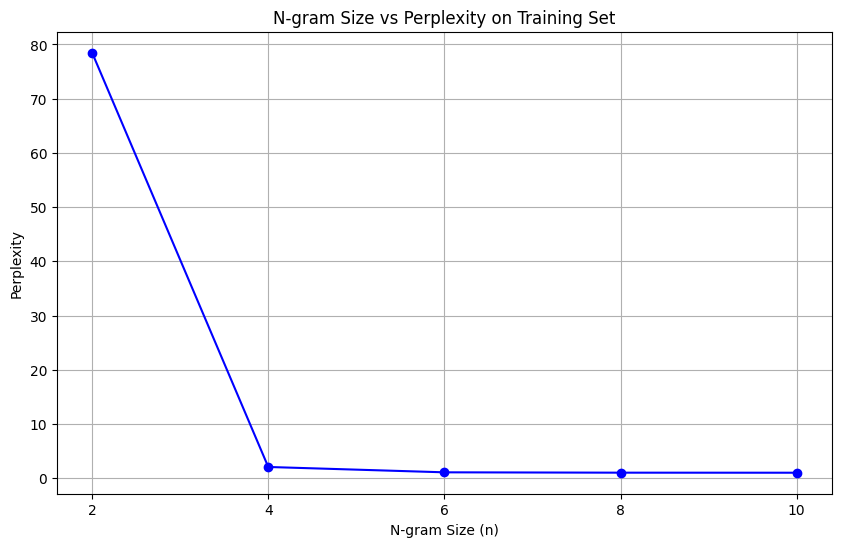

In [13]:
# =============================
# TODO: create the plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(values, perplexities, marker='o', linestyle='-', color='b')
plt.xlabel("N-gram Size (n)")
plt.ylabel("Perplexity")
plt.title("N-gram Size vs Perplexity on Training Set")
plt.xticks(values)
plt.grid(True)
plt.show()

**TODO**: In the Markdown cell below, explain the effect you observe, why do you think this is the case?

From the graph we can see that the perplexity value decreases as the N-gram value increases i.e an inverse relationship. This is because as the context becomes wider (n-value) the amount of words it remembers increases so that the random-ness will drop.